In [314]:
!pip install transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import sys
import csv
import seaborn as sb
from collections import OrderedDict
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score
from transformers import BertTokenizer
import torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [315]:
csv.field_size_limit(sys.maxsize)
nltk.download('stopwords')
nltk.download('punkt')
stop_words = stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [316]:
labels = ['fake', 'real']

In [317]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [318]:
news_data = pd.read_csv('WELFake_Dataset.csv', engine='python', encoding='utf-8', on_bad_lines='skip').fillna('')

news_data_smaller = news_data.sample(n=10).reset_index(drop=True)

In [319]:
def remove_punctuation(some_string):
    unpuncted_string = some_string.translate(str.maketrans("","",string.punctuation))
    unpuncted_string = unpuncted_string.translate(str.maketrans("","","—"))
    return(unpuncted_string)

In [320]:
def apply_stemming(some_string):
    new_list = []
    for word in some_string.split():
        word = stemmer.stem(word)
        new_list.append(word)
    return(new_list)

In [321]:
news_data = news_data_smaller

In [322]:
news_data["title_clean"] = news_data["title"].apply(lambda x: " ".join([word for word in str(x).lower().split() if word not in (stop_words)]))
news_data["title_clean"] = news_data["title_clean"].apply(remove_punctuation)
news_data["title_clean"] = news_data["title_clean"].apply(apply_stemming)


In [323]:
news_data["text_clean"] = news_data["text"].apply(lambda x: " ".join([word for word in str(x).lower().split() if word not in (stop_words)]))
news_data["text_clean"] = news_data["text_clean"].apply(remove_punctuation)
news_data["text_clean"] = news_data["text_clean"].apply(apply_stemming)

In [324]:
news_data

,Unnamed: 0,title,text,label,title_clean,text_clean
0,25517,Clinton Foundation plans to close overseas fun...,"NEW YORK (Reuters) - The Bill, Hillary & Chels...",0,"[clinton, foundat, plan, close, oversea, fundr...","[new, york, reuter, bill, hillari, chelsea, cl..."
1,3168,YALE REMOVES Name Of DEMOCRAT White Supremacis...,"University trustees, known as the Yale Corpora...",1,"[yale, remov, name, democrat, white, supremaci...","[univers, truste, known, yale, corpor, vote, f..."
2,60001,"House adopts massive defense bill, sees change...",WASHINGTON (Reuters) - The U.S. House of Repre...,0,"[hous, adopt, massiv, defens, bill, see, chang...","[washington, reuter, us, hous, repres, pass, d..."
3,38855,Trump lifts Cyber Command status to boost cybe...,WASHINGTON (Reuters) - President Donald Trump ...,0,"[trump, lift, cyber, command, status, boost, c...","[washington, reuter, presid, donald, trump, sa..."
4,49230,When Eve and Eve Bit the Apple - The New York ...,When you are raised to be a good Christian gir...,0,"[eve, eve, bit, appl, new, york, time]","[rais, good, christian, girl, don't, go, churc..."
5,41214,Visualizing the influx of Rohingya refugees,(Reuters) - United Nations aid agencies said t...,0,"[visual, influx, rohingya, refuge]","[reuter, unit, nation, aid, agenc, said, week,..."
6,61375,Ann Coulter Makes SICK Comparison Between Hil...,Far-right conservative and resident anti-Semit...,1,"[ann, coulter, make, sick, comparison, hillari...","[farright, conserv, resid, antisemit, bigot, a..."
7,30748,Mannequin Challenge goes completely unnoticed ...,Friday 18 November 2016 by Alex Webster Manneq...,1,"[mannequin, challeng, goe, complet, unnot, sou...","[friday, 18, novemb, 2016, alex, webster, mann..."
8,59907,Samantha Bee: America Does Not Have a ’Smug Li...,"Sunday on CNN’s “State of the Union,” TBS’s “F...",0,"[samantha, bee, america, smug, liber, problem,...","[sunday, cnn, “state, union”, tbs, “full, fron..."
9,8285,CEI v. The Attorney General of New York | Libe...,(Before It's News)\nNew York Attorney General ...,1,"[cei, v, attorney, general, new, york, liberta...","[befor, news, new, york, attorney, general, er..."


In [325]:
def calculate_word_occurences(text, labels):
  occurence = {}
  occurence_in_fake_articles = {}
  occurence_in_real_articles = {}
  for sentence, label in zip(news_data["text_clean"], news_data["label"]):
    for word in sentence:
      if label == 1:
        if word in occurence_in_real_articles:
          occurence_in_real_articles[word] += 1
        else:
          occurence_in_real_articles[word] = 1
      else:
        if word in occurence_in_fake_articles:
          occurence_in_fake_articles[word] += 1
        else:
          occurence_in_fake_articles[word] = 1


      if word in occurence:
        occurence[word] += 1
      else:
        occurence[word] = 1

  occurence = dict(sorted(occurence.items(), key=lambda item: item[1], reverse=True))
  
  return occurence, occurence_in_fake_articles, occurence_in_real_articles

In [326]:
word_occurence, occurrence_fake, occurrence_real = calculate_word_occurences(news_data["text_clean"], news_data["label"])

word_occurence_top = {k: word_occurence[k] for k in list(word_occurence)[:10]}

occurrence_real, occurrence_fake

({'univers': 4,
  'truste': 1,
  'known': 4,
  'yale': 10,
  'corpor': 1,
  'vote': 1,
  'favor': 1,
  'renam': 4,
  'friday': 5,
  'revers': 1,
  'decis': 1,
  'last': 2,
  'year': 3,
  'keep': 3,
  'name': 6,
  'defend': 1,
  'way': 3,
  'confront': 1,
  'rather': 1,
  'paper': 1,
  'legaci': 2,
  'slaveryth': 1,
  'chang': 2,
  'go': 3,
  'effect': 1,
  'time': 2,
  '20172018': 1,
  'academ': 1,
  'john': 2,
  'c': 1,
  'calhoun': 5,
  'white': 2,
  'supremacist': 2,
  'nation': 1,
  'leader': 1,
  'passion': 1,
  'promot': 2,
  'slaveri': 3,
  'posit': 1,
  'good': 2,
  'fundament': 1,
  'conflict': 1,
  'mission': 1,
  'valu': 1,
  'presid': 3,
  'peter': 1,
  'salovey': 1,
  'said': 5,
  'messag': 1,
  'sent': 1,
  'communiti': 1,
  'saturday': 1,
  'depict': 1,
  'colleg': 6,
  'celebr': 1,
  'plantat': 1,
  'old': 1,
  'south': 1,
  'suggest': 2,
  'honor': 2,
  'part': 1,
  'support': 4,
  'spite': 1,
  'ityal': 1,
  'among': 2,
  'number': 1,
  'grappl': 1,
  'histori': 2,
  

In [327]:
def generate_plot_data(word_occurences, occurence_in_fake_articles, occurence_in_real_articles):
  words_x = []
  words_fake = []
  words_real = []

  for word in word_occurences:
    if (word not in occurence_in_fake_articles):
      words_fake.append(0)
    else:
      words_fake.append(occurence_in_fake_articles[word])

    if (word not in occurence_in_real_articles):
      words_real.append(0)
    else:
      words_real.append(occurence_in_real_articles[word])

    words_x.append(word)
    
  return words_x, words_fake, words_real

In [328]:
news_data["label"].value_counts()

0    6
1    4
Name: label, dtype: int64

<BarContainer object of 2 artists>

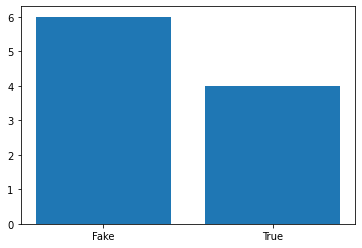

In [329]:
x = np.array(["Fake", "True"])
y = np.array([news_data['label'].value_counts()[0], news_data['label'].value_counts()[1]])

plt.bar(x,y)

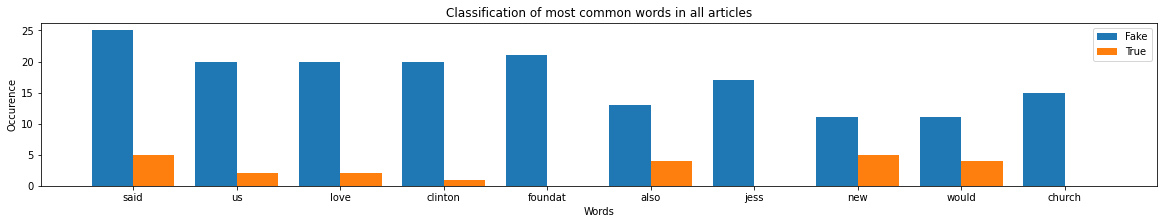

In [335]:
words_x, words_fake, words_true = generate_plot_data(word_occurence_top, occurrence_fake, occurrence_real)
X_axis = np.arange(len(words_x))
plt.figure(figsize=(20, 3)) 
plt.bar(X_axis - 0.2, words_fake, 0.4, label = 'Fake')
plt.bar(X_axis + 0.2, words_true, 0.4, label = 'True')


plt.xticks(X_axis, words_x)
plt.xlabel("Words")
plt.ylabel("Occurence")
plt.title("Classification of most common words in all articles")
plt.legend()
plt.show()

In [331]:
def bow_maker(some_list):
    bow = set()
    for word in some_list:
        numbr = some_list.count(word)
        bow.add((word, numbr))
    return(bow)

print(news_data["title_clean"].apply(bow_maker)[0])

{('plan', 1), ('close', 1), ('oversea', 1), ('fundrais', 1), ('foundat', 1), ('clinton', 1), ('arm', 1)}


In [332]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [333]:
texts = news_data["title"].values
labels = news_data['label'].values

In [334]:
texts

array(['Clinton Foundation plans to close overseas fundraising arms',
       'YALE REMOVES Name Of DEMOCRAT White Supremacist, Passionate Supporter Of Slavery From Res College…Why Not Rename It After Most Famous Black Alum, Justice Clarence Thomas?',
       'House adopts massive defense bill, sees changes under Trump',
       'Trump lifts Cyber Command status to boost cyber defense',
       'When Eve and Eve Bit the Apple - The New York Times',
       'Visualizing the influx of Rohingya refugees',
       ' Ann Coulter Makes SICK Comparison Between Hillary And Hitler In Asking Where Bernie’s Fans Went',
       'Mannequin Challenge goes completely unnoticed at Southern Rail',
       'Samantha Bee: America Does Not Have a ’Smug Liberal Problem’ - Breitbart',
       'CEI v. The Attorney General of New York | Libertarian'],
      dtype=object)